## Section 1 — Train/Test Split

In this section, we split the dataset into training and testing subsets using an 80/20 ratio.  
A fixed `random_state` ensures reproducibility, while `shuffle=True` randomizes the observations before splitting.  
We also capture the resulting index positions for reference during evaluation.


In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, precision_recall_curve, auc,
    classification_report, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample

#import our data from 01_eda
df = pd.read_csv("../gold_macro_features.csv")

#  Features
features_v3 = [
    "Open", "High", "Low", "Close", "Volume",
    "MA20", "MA200", "Momentum_10", "Momentum_50", "ROC_4w",
    "Volatility", "DollarReturn", "YieldChange", "RSI",
    "Gold_to_Dollar", "Gold_to_Yield", "Gold_to_SPX",
    "Lag1", "Lag5", "Vol_5", "RSI_Change", "DollarLag", "YieldLag"
]

X = df[features_v3]
y = df["Target"]

train_size = int(0.8 * len(df))

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=102,   
    shuffle=True        
)

# Get the random indices
train_idx = X_train.index
test_idx = X_test.index

## Section 2 — Define and Configure LightGBM Model

Here we initialize the LightGBM classifier using a set of tuned hyperparameters.  
The class imbalance ratio is computed from the training set and passed to the model to balance the positive and negative classes.  
These hyperparameters control the model’s complexity, learning speed, and regularization.


In [8]:
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

lgb_model = lgb.LGBMClassifier(
    num_leaves=63,
    learning_rate=0.02,
    n_estimators=800,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    min_child_samples=25,
    objective="binary",
    scale_weight = ratio,
    random_state=42,
    n_jobs=-1
)

## Section 3 — Train the Model with Early Stopping

We train the LightGBM model on clipped feature values to reduce the influence of extreme outliers.  
An evaluation set (the test split) is provided to monitor validation performance.  
Early stopping halts training once the model stops improving, preventing overfitting.


In [9]:
lgb_model.fit(
    X_train.clip(-5, 5), y_train,
    eval_set=[(X_test.clip(-5, 5), y_test)],
    eval_metric="logloss",
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
)

[LightGBM] [Warning] Unknown parameter: scale_weight
[LightGBM] [Warning] Unknown parameter: scale_weight
[LightGBM] [Info] Number of positive: 2616, number of negative: 2092
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3576
[LightGBM] [Info] Number of data points in the train set: 4708, number of used features: 15
[LightGBM] [Warning] Unknown parameter: scale_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.555650 -> initscore=0.223526
[LightGBM] [Info] Start training from score 0.223526
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[793]	valid_0's binary_logloss: 0.549154


,boosting_type,'gbdt'
,num_leaves,63
,max_depth,-1
,learning_rate,0.02
,n_estimators,800
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,25


## Section 4 — Determine Optimal Classification Threshold

Rather than using the default 0.5 decision threshold, we calculate precision and recall across all possible thresholds.  
The F1 score is computed for each threshold, and the threshold that maximizes the F1 score is selected.  
This helps improve predictive balance, especially under class imbalance.


In [10]:
y_proba = lgb_model.predict_proba(X_test.clip(-5, 5))[:, 1]
p, r, th = precision_recall_curve(y_test, y_proba)
f1 = 2*p*r/(p+r+1e-6)
best_thresh = th[np.argmax(f1)]
print("Optimal threshold:", best_thresh)
y_pred = (y_proba > best_thresh).astype(int)

[LightGBM] [Warning] Unknown parameter: scale_weight
Optimal threshold: 0.4616907118615634


## Section 5 — Model Evaluation and Metrics

We evaluate performance using several classification metrics:  
- **Accuracy** — overall percentage of correct predictions  
- **F1 Score** — harmonic mean of precision and recall  
- **ROC AUC** — ability to distinguish between classes across probability thresholds  
- **PR AUC** — precision–recall tradeoff area, useful for imbalanced datasets  

A full classification report is also generated to show precision, recall, and F1 per class.


In [11]:
y_pred = lgb_model.predict(X_test)
y_proba = lgb_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

print(f"\n✅ GOLD PREDICTOR v3 — LightGBM Performance:")
print(f"Accuracy:  {acc:.3f}")
print(f"F1 Score:  {f1:.3f}")
print(f"ROC AUC:   {roc_auc:.3f}")
print(f"PR AUC:    {pr_auc:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

[LightGBM] [Warning] Unknown parameter: scale_weight
[LightGBM] [Warning] Unknown parameter: scale_weight

✅ GOLD PREDICTOR v3 — LightGBM Performance:
Accuracy:  0.730
F1 Score:  0.771
ROC AUC:   0.798
PR AUC:    0.816

Classification Report:
              precision    recall  f1-score   support

           0      0.753     0.604     0.671       536
           1      0.716     0.835     0.771       641

    accuracy                          0.730      1177
   macro avg      0.735     0.720     0.721      1177
weighted avg      0.733     0.730     0.725      1177



## Section 6 — Confusion Matrix Visualization

The confusion matrix provides a detailed view of prediction outcomes, including:  
- True Positives  
- False Positives  
- True Negatives  
- False Negatives  

This visualization helps us understand where the model makes errors and how balanced its predictions are.


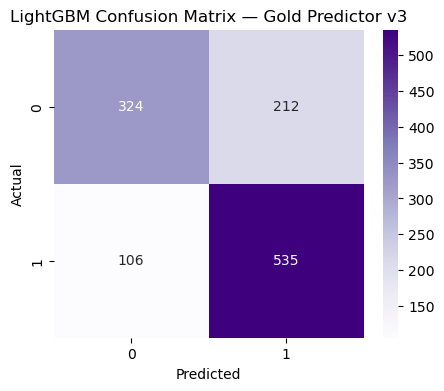

In [14]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("LightGBM Confusion Matrix — Gold Predictor v3")
plt.savefig("../results/lightgbm_confusion_matrix.png", bbox_inches="tight")
plt.show()

## Section 7 — Feature Importance Plot

LightGBM provides built-in feature importance scores based on information gain.  
We plot the top contributing features to understand which variables have the strongest influence on gold direction prediction.  
This enhances interpretability and provides insight into which financial or macroeconomic indicators the model relies on.


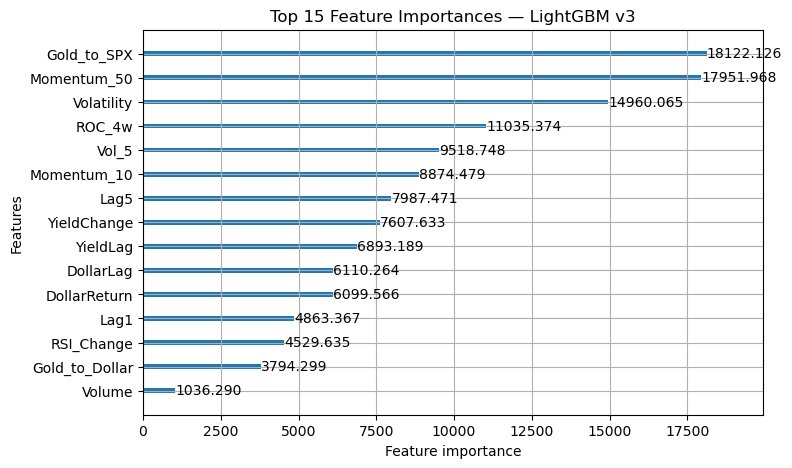

In [15]:
lgb.plot_importance(lgb_model, max_num_features=15, importance_type="gain", figsize=(8, 5))
plt.title("Top 15 Feature Importances — LightGBM v3")
plt.savefig("../results/lightgbm_feature_importance.png", bbox_inches="tight")
plt.show()

## ROC Curve — Model Discrimination Ability

The ROC curve illustrates how well the LightGBM model separates the two classes (Up vs. Down) across all possible probability thresholds.  
A higher curve indicates better discrimination, meaning the model assigns higher predicted probabilities to positive cases than negative ones.  
The area under the curve (ROC AUC) provides a single performance summary:  
- **1.0** = perfect classifier  
- **0.5** = no better than random  
A strong ROC curve suggests the model captures meaningful patterns in the gold + macroeconomic features.


[LightGBM] [Warning] Unknown parameter: scale_weight


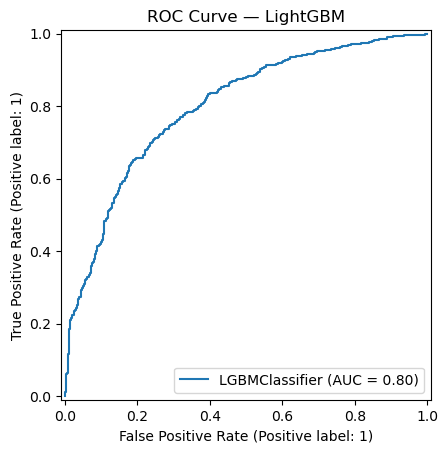

In [16]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(lgb_model, X_test, y_test)
plt.title("ROC Curve — LightGBM")
plt.savefig("../results/lightgbm_roc_curve.png", bbox_inches="tight")
plt.show()
